<a href="https://colab.research.google.com/github/mayankshouche/DSLabFinalProject/blob/main/Bert_Fine_Tuning" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets tweet-preprocessor

     |████████████████████████████████| 1.4MB 22.6MB/s 
     |████████████████████████████████| 163kB 61.2MB/s 
     |████████████████████████████████| 890kB 51.0MB/s 
     |████████████████████████████████| 2.9MB 51.3MB/s 
     |████████████████████████████████| 17.7MB 214kB/s 
     |████████████████████████████████| 245kB 59.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=d0804bb7803dc3567e9736ddc7a1e12e354fbfb6268863d57b9742429b3a4149
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns
import torch

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, roc_auc_score
from datasets import Dataset
from sklearn.model_selection import train_test_split
from scipy.special import softmax
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm

In [81]:
dataset = pd.read_csv('/content/drive/MyDrive/Copy of tweets_3k.csv', index_col=0)
dataset.head()

,Created-At,From-User-Id,To-User-Id,Language,Retweet-Count,PartyName,Id,Score,Scoring String,Negativity,Positivity,Uncovered Tokens,Total Tokens,State,Text
0,2020-10-05 13:48:00,267405095,-1,en,1264.0,Democrats,1313068582805270529,1.487179,actively (0.33) win (0.72) party (0.44),0.0,1.487179,26,29,Arizona,"RT @IngrahamAngle: Reminder: China, still acti..."
1,2020-09-10 04:25:00,29928823,-1,en,105.0,Republicans,1303867078458445826,1.307692,smart (0.44) smart (0.44) smart (0.44),0.0,1.307692,24,27,North Carolina,RT @MsAvaArmstrong: Smart suburban women WILL ...
2,2020-07-13 07:50:00,13165482,-1,en,538.0,Republicans,1282537894121484288,1.179487,trust (0.59) trust (0.59),0.0,1.179487,30,32,Texas,RT @AynRandPaulRyan: 26% of voters trust Trump...
3,2020-11-05 06:48:00,479964312,-1,en,70136.0,Democrats,1324196851034345472,1.564103,supporters (0.49) like (0.38) won (0.69),0.0,1.564103,19,22,Iowa,RT @Vic_Goes: Tr*mp supporters really abt to b...
4,2020-08-20 04:11:00,987817704072495104,-1,en,16267.0,Democrats,1296253496061120514,1.076923,proud (0.54) proud (0.54),0.0,1.076923,29,31,Utah,RT @NaomiBiden: I am proud to be your granddau...


States: 50


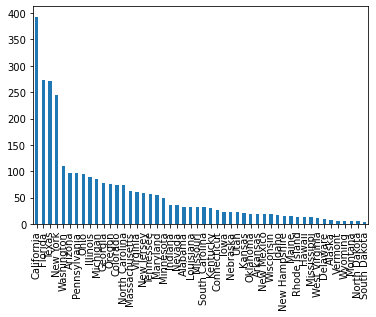

In [82]:
print(f"States: {dataset['State'].nunique()}")
dataset["State"].value_counts().plot.bar()

### Build dataset for classification

In [83]:
dataset_final = dataset.copy()

LABEL_MAP = {
    "AntiDemocrats": 0,
    "ProDemocrats": 1,
    "AntiRepublicans": 2,
    "ProRepublicans": 3
}

def buildLabels(row):
  if row["Score"] < 0:
    return LABEL_MAP.get("Anti" + row["PartyName"])
  else:
    return LABEL_MAP.get("Pro" + row["PartyName"])

def cleanTweet(row):
  tweet = row["Text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["label"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [84]:
dataset_final.drop(columns=['Created-At', 'From-User-Id', 'To-User-Id', 'Language',
                           'Retweet-Count', 'PartyName', 'Id', 'Score', 'Scoring String',
                           'Negativity', 'Positivity', 'Uncovered Tokens', 'Total Tokens'],
                   inplace=True)

In [85]:
X_train, X_val, y_train, y_val = train_test_split(dataset_final.index.values, 
                                                  dataset_final.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=dataset_final.label.values)

dataset_final['data_type'] = ['not_set']*dataset_final.shape[0]

dataset_final.loc[X_train, 'data_type'] = 'train'
dataset_final.loc[X_val, 'data_type'] = 'test'
dataset_final.groupby(['label', 'data_type']).count()

State  Text  clean_text
label data_type                         
0     test          35    35          35
      train        197   197         197
1     test          73    73          73
      train        415   415         415
2     test         189   189         189
      train       1068  1071        1071
3     test         148   148         148
      train        836   838         838

### Try out BERTForSequenceClassification to see how it goes

In [87]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(0.0, 128.0)

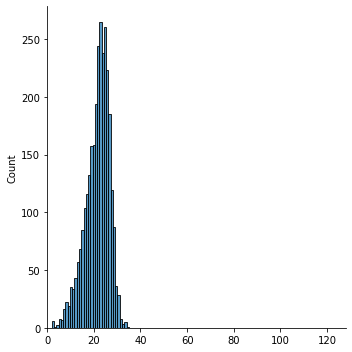

In [88]:
# find distribution of length of tokenized tweets
lens = []

for tweet in dataset_final.clean_text:
  tokens = tokenizer.encode(tweet, max_length=512)
  lens.append(len(tokens))

sns.displot(lens)
plt.xlim([0, 128])

In [98]:
# tokenize train and test data so BERT can understand it
encoded_data_train = tokenizer.batch_encode_plus(
    dataset_final[dataset_final.data_type=='train'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True,
    max_length=64, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    dataset_final[dataset_final.data_type=='test'].clean_text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding=True, 
    max_length=64, 
    return_tensors='pt'
)


# destructure out the input_ids, attention masks, and labels from tokenizer & encoder output
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset_final[dataset_final.data_type=='train'].label.values)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(dataset_final[dataset_final.data_type=='test'].label.values)

In [100]:
train_data = TensorDataset(input_ids_train, attention_masks_train, labels_train)
test_data = TensorDataset(input_ids_test, attention_masks_test, labels_test)

BATCH_SIZE = 8

train_dataloader = DataLoader(train_data, 
                              sampler=RandomSampler(train_data), 
                              batch_size=BATCH_SIZE)

test_dataloader = DataLoader(test_data,
                             sampler=SequentialSampler(test_data),
                             batch_size=BATCH_SIZE)

In [101]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=4,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [102]:
EPOCHS = 5

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0, 
                                            num_training_steps=len(train_dataloader)*EPOCHS)

In [103]:
def auc_score(preds, labels):
  soft_preds = softmax(preds, axis=1) # logit -> probability
  return roc_auc_score(labels, soft_preds, multi_class='ovr')

def acc_score_by_class(preds, labels):
  label_dict_inverse = {v: k for k, v in LABEL_MAP.items()} 

  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {label_dict_inverse[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

following is mostly taken from [this medium article](https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613)

In [104]:
def evaluate(dataloader):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []
  
  for batch in dataloader:
      
      # convert data to CUDA
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      with torch.no_grad():        
          outputs = model(**inputs) # get predictions
          
      loss = outputs[0]
      logits = outputs[1]
      loss_val_total += loss.item()

      logits = logits.detach().cpu().numpy()
      label_ids = inputs['labels'].cpu().numpy()
      predictions.append(logits)
      true_vals.append(label_ids)
  
  loss_val_avg = loss_val_total/len(dataloader) 
  
  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
          
  return loss_val_avg, predictions, true_vals

In [ ]:
import random

seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [106]:
print(device)
torch.cuda.get_device_name(0)

cuda


'Tesla T4'

In [107]:
for epoch in tqdm(range(1, EPOCHS+1)): # use tqdm for a progress bar
  model.train() # enter training mode
  loss_train_total = 0

  progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch}', leave=False, disable=False)
  for batch in progress_bar:
      model.zero_grad()
      
      # get CUDA data
      batch = tuple(b.to(device) for b in batch)
      
      inputs = {
          'input_ids':      batch[0],
          'attention_mask': batch[1],
          'labels':         batch[2],
      }

      outputs = model(**inputs) # evaluate
      
      # for reference, we are using cross-entropy loss here,
      # as implemented in https://huggingface.co/transformers/_modules/transformers/modeling_bert.html
      loss = outputs[0]
      loss_train_total += loss.item()
      loss.backward() # do backprop

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      scheduler.step()
      
      progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
        
      
  torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_BERT_epoch_{epoch}.model')
      
  tqdm.write(f'\nEpoch {epoch}')
  
  loss_train_avg = loss_train_total/len(train_dataloader)            
  tqdm.write(f'Training loss: {loss_train_avg}')
  
  val_loss, predictions, true_vals = evaluate(test_dataloader)
  auc = auc_score(predictions, true_vals)
  tqdm.write(f'Testing loss: {val_loss}')
  tqdm.write(f'AUC: {auc}')


Epoch 1
Training loss: 0.8068105222869523
Testing loss: 0.47174283489584923
AUC: 0.9561602080670061



Epoch 2
Training loss: 0.3969964378902429
Testing loss: 0.4183510930077838
AUC: 0.9616062380521392



Epoch 3
Training loss: 0.26676357622977487
Testing loss: 0.3663029841845855
AUC: 0.9691803783179397



Epoch 4
Training loss: 0.20062267333357536
Testing loss: 0.42970010355514077
AUC: 0.9674363605136527



Epoch 5
Training loss: 0.14935231977584476
Testing loss: 0.4369828942165311
AUC: 0.9684803161664683



In [108]:
_, preds, true_vals = evaluate(test_dataloader)
acc_score_by_class(preds, true_vals)

Class: AntiDemocrats
Accuracy: 26/35

Class: ProDemocrats
Accuracy: 52/73

Class: AntiRepublicans
Accuracy: 184/189

Class: ProRepublicans
Accuracy: 134/148

